In [1]:
from google.colab import drive
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import datetime
import os
import h5py
import torch
import pickle
from torch import nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset, random_split

In [2]:
model_checkpoint_save_path = './models/checkpoints/'
dtype = torch.float32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(dtype)
print(device)

torch.float32
cuda:0


# Connect Colab and Google Drive

In [3]:
# Path to where deeplearningproject is stored on drive that contains the data and the git repo (may have to be changed depending on user)
# Note can just use Colab terminal with git commands to commit, pull, push, etc. (Note have to follow this to push: https://stackoverflow.com/a/65951928/14018615)
deep_learn_drive_path = '/content/drive/MyDrive/CS 6955/deeplearningproject/'
# To use with colab
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
# cd into git repo
os.chdir(deep_learn_drive_path + 'cs-6955-deep-learning-final-project')
print('Git directory content: {0}'.format(os.listdir()))

Git directory content: ['porositydata_howto.py', '.git', 'README.md', 'models', 'porositydataset.hdf5', '.gitignore', 'PorousMaterialImageToYoungsModulusNet.ipynb', 'porositydataset_2000runs.hdf5', 'PorousMaterialImageToYoungsModulusNet_dkbirky.ipynb', 'PorousMaterialImageAndStrainToStressNet.ipynb']


In [5]:
porosity_dataset_filename = 'porositydataset_2000runs.hdf5'
# porosity_dataset_filename = 'porositydataset.hdf5'

# Create PyTorch Dataset 

In [6]:
class PorousMaterialImageAndStrainToStressDataset(Dataset):
    def __init__(self, hdf5_porosity_path, img_transform=None):
        self.img_transform = img_transform
        ##load the dataset
        self.d = h5py.File(hdf5_porosity_path,'a')
        #load original images
        self.og_images = np.zeros(self.d['Original Images'].shape)
        self.og_images[:,:,:] = self.d['Original Images']
        #load deformed images
        self.deformed_images = np.zeros(self.d['Deformed Images'].shape)
        self.deformed_images[:,:,:] = self.d['Deformed Images']
        #load stress-strain data
        self.ss_data = np.zeros(self.d['Data'].shape)
        self.ss_data[:,:,:] = self.d['Data']
        #separate stresses/strains, stresses in MPa, strain is unitless
        self.SMises = self.ss_data[:,0,:] #von Mises stress
        self.S11 = self.ss_data[:,1,:] #stress in 11 direction
        self.S22 = self.ss_data[:,2,:] #stress in 22 direction
        self.SP = self.ss_data[:,3,:] #pressure stress
        self.strain = self.ss_data[:,4,:]*0.006 #strain (have to multiply by 0.006 to get value)
        #load youngs moduli, units are GPa
        self.E = np.zeros(self.d['Youngs Modulus'].shape)
        self.E[:] = self.d['Youngs Modulus']
        
    def __len__(self):
        return self.E.size

    def __getitem__(self, idx):
        og_image_idx = self.og_images[idx,:,:,:].astype('uint8')
        deformed_image_idx = self.deformed_images[idx,:,:,:].astype('uint8')
        if (self.img_transform is not None):
            og_image_idx = self.img_transform(og_image_idx)
            deformed_image_idx = self.img_transform(deformed_image_idx)
        SMises_idx = self.SMises[idx,:]
        S11_idx = self.S11[idx,:]
        S22_idx = self.S22[idx,:]
        SP_idx = self.SP[idx,:]
        strain_idx = self.strain[idx,:]
        E_idx = self.E[idx]
        # Will be using og_images and strain to get SMises
        return og_image_idx, strain_idx, SMises_idx

In [7]:
# Load porous dataset into memory
porous_dataset = PorousMaterialImageAndStrainToStressDataset(porosity_dataset_filename, img_transform=transforms.Compose([transforms.ToPILImage(), transforms.Resize(224), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])]))

In [8]:
# Split into train and test
test_prop = 0.2
test_size = int(test_prop*len(porous_dataset))
train_size = len(porous_dataset) - test_size
porous_train_dataset, porous_test_dataset = random_split(porous_dataset, (train_size, test_size)) 

# Split train into train and val
val_prop = 0.2
val_size = int(val_prop*len(porous_train_dataset))
train_size = len(porous_train_dataset) - val_size
porous_train_dataset, porous_val_dataset = random_split(porous_train_dataset, (train_size, val_size)) 

In [9]:
batch_size = 32
train_loader = DataLoader(porous_train_dataset, batch_size=batch_size, shuffle=True)

# Batch size doesn't really matter for testing
test_loader = DataLoader(porous_test_dataset)
val_loader = DataLoader(porous_val_dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


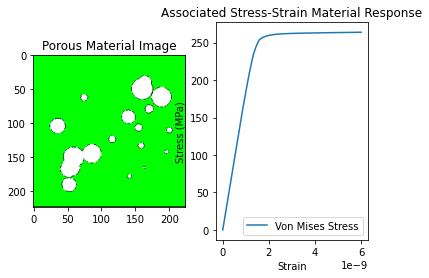

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


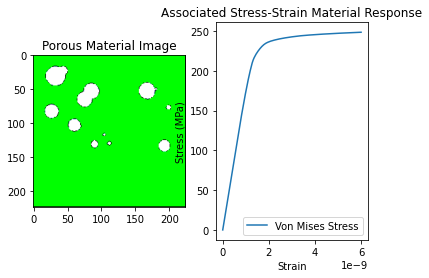

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


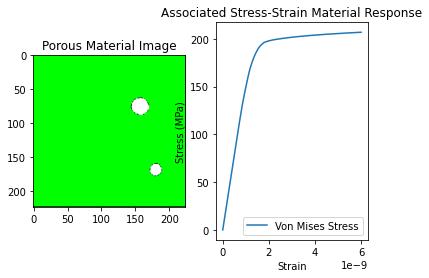

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


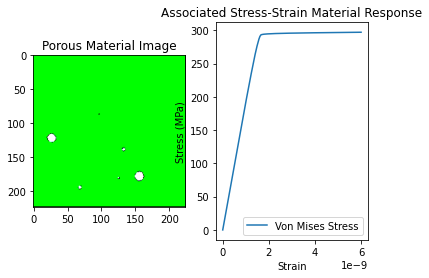

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


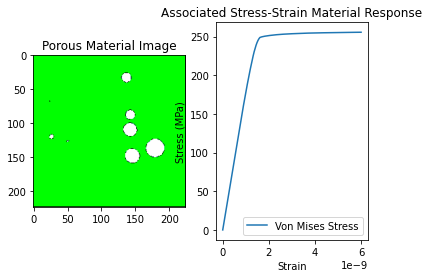

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


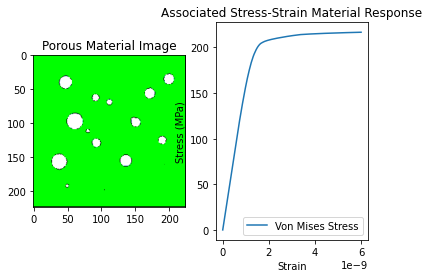

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


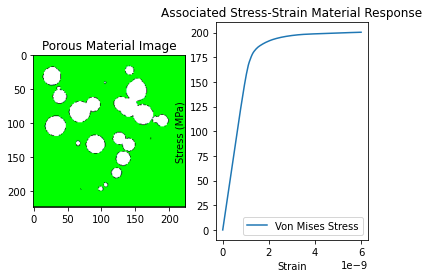

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


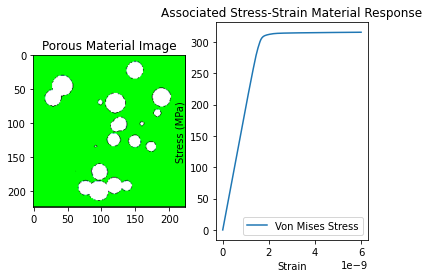

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


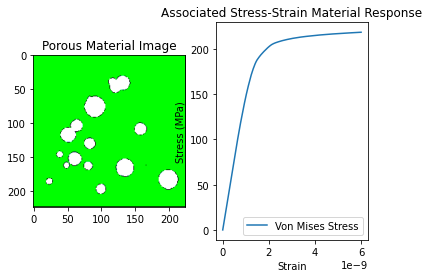

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


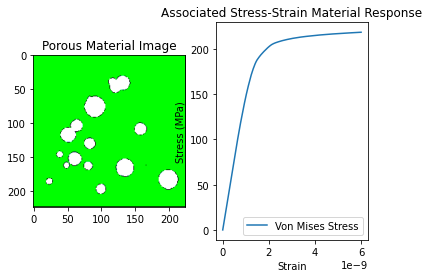

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


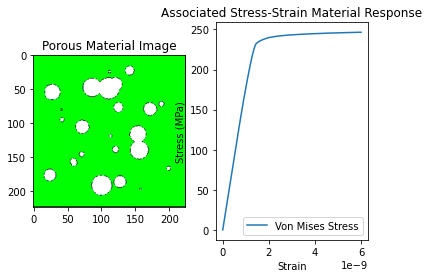

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


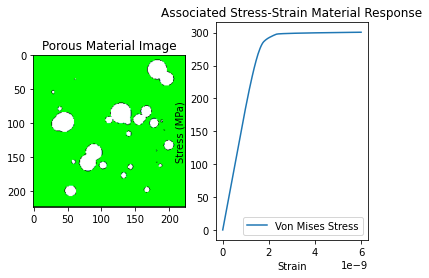

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


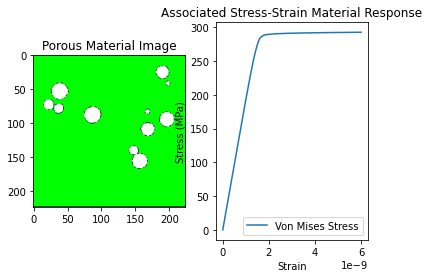

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


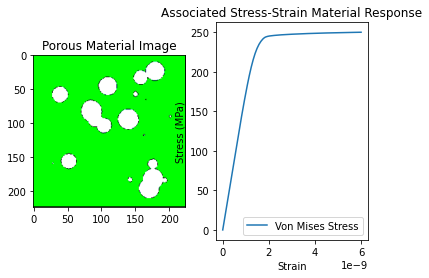

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


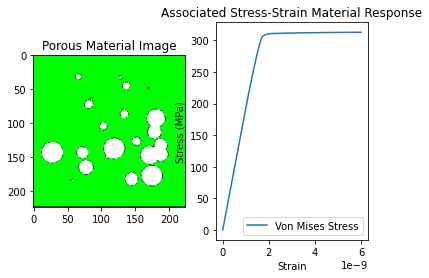

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


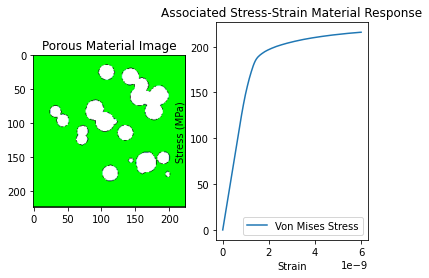

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


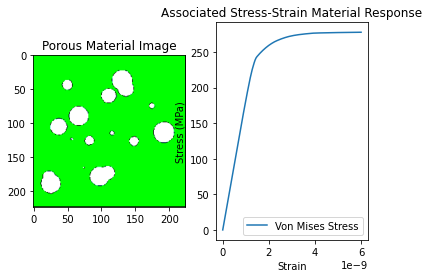

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


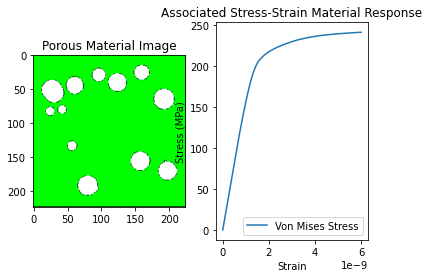

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


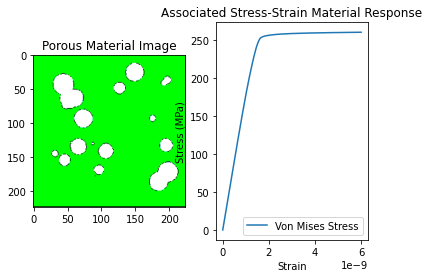

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


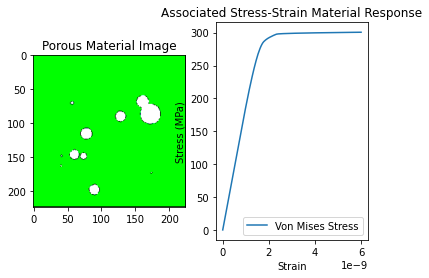

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


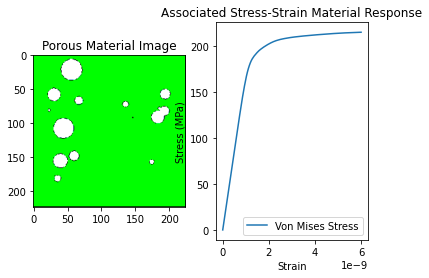

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


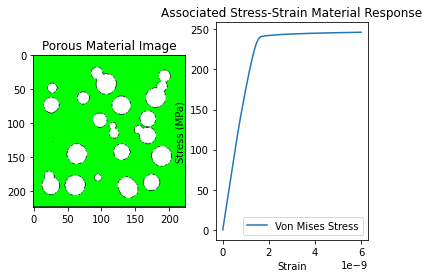

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


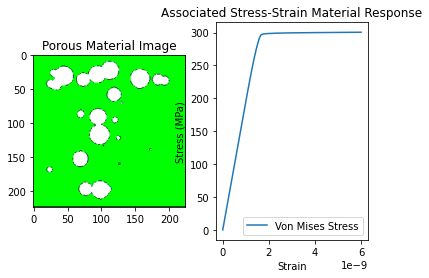

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


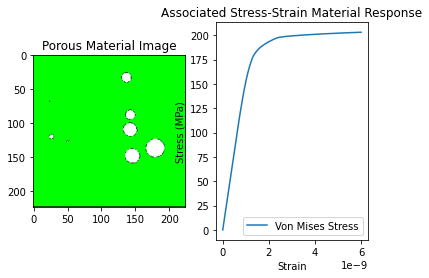

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


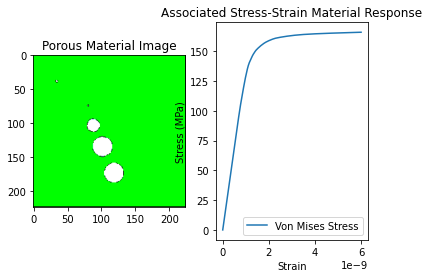

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


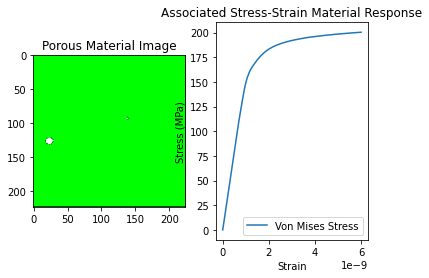

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


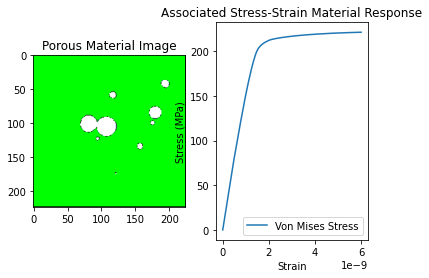

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


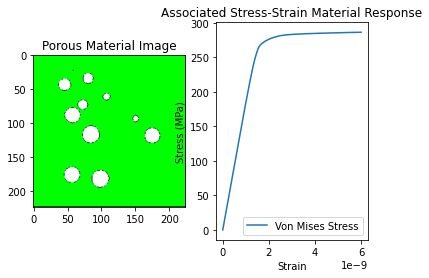

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


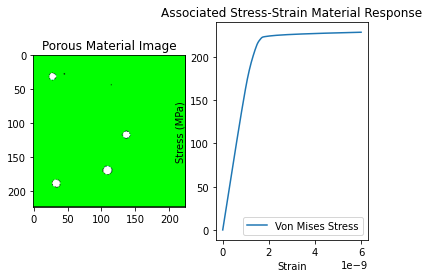

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


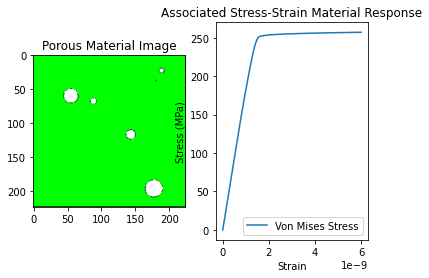

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


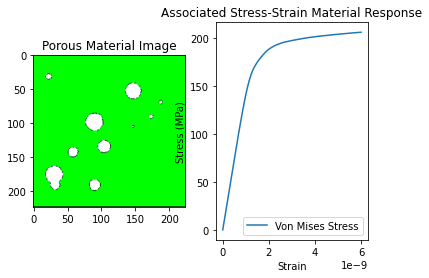

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


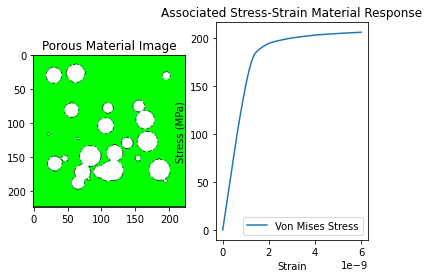

In [10]:
# Visualize train data of a random batch 
viz_batch_idx = random.randint(0, len(train_loader)-1)
for i, batch in enumerate(train_loader):
    if i != viz_batch_idx:
        continue
    og_image_batch, strain_batch, SMises_batch = batch
    for idx in range(len(og_image_batch)):
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
        ax1.imshow(torch.movedim(og_image_batch[idx], 0, 2))
        ax1.set_title('Porous Material Image')
        ax2.plot(strain_batch[idx], SMises_batch[idx], label='Von Mises Stress')
        ax2.set_xlabel('Strain') # mm?
        ax2.set_ylabel('Stress (MPa)')
        ax2.set_title('Associated Stress-Strain Material Response')
        ax2.legend()
        plt.show()


# Training

In [40]:
class PorousMaterialImageAndStrainToStressNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_net = nn.Sequential(
            *(list(models.squeezenet1_1(pretrained=True).children()))
            ) # Nx2x224x224=>Nx1000x1x1
        
        self.connector_net = nn.Sequential(
            nn.Linear(1000, 1), # 1xNx1000 => 1xNx1
        )

        self.recurrent_net_model = nn.LSTM(input_size=1, hidden_size=1, batch_first=True) # input: NxLxinput_size, h_0: 1xNxhidden_size, => NxLxhidden_size

    def forward(self, og_images, strains):
        conv_out = self.conv_net(og_images) # Nx2x224x224=>Nx1000x1x1
        conv_out = torch.unsqueeze(torch.squeeze(torch.squeeze(conv_out, dim=2), dim=2), dim=0) # Nx1000x1x1 => 1xNx1000
        connect_out = self.connector_net(conv_out) # 1xNx1000 => 1xNx1
        recurrent_out = self.recurrent_net_model(torch.unsqueeze(strains, dim=2), (connect_out, torch.zeros_like(connect_out))) #  input:NxL=>NxLx1, h_0:1xNx1 => NxLx1
        stresses = recurrent_out[0]
        return torch.squeeze(stresses, dim=2) # NxLx1 => NxL


In [41]:
def get_PorousMaterialImageAndStrainToStressNet_accuracy(model, evaluation_dataloader, criterion):
    model.eval()
    model = model.to(device=device)
    total_MSE = 0
    num_vals = 0
    with torch.no_grad():
        for eval_batch in evaluation_dataloader:
            og_image_batch, strain_batch, SMises_batch = eval_batch
            og_image_batch = og_image_batch.to(dtype=dtype, device=device)
            strain_batch = strain_batch.to(dtype=dtype, device=device)
            SMises_batch = SMises_batch.to(dtype=dtype, device=device)

            pred_SMises_batch = model(og_image_batch, strain_batch)

            total_MSE += criterion(pred_SMises_batch, SMises_batch).cpu()
            num_vals += 1
    avg_MSE = total_MSE / num_vals
    return total_MSE, avg_MSE 

In [42]:
model = PorousMaterialImageAndStrainToStressNet()

learning_rate = 1e-3
nepochs = 50
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [43]:
train_avg_MSE_vals = []
val_avg_MSE_vals = []
date_str = datetime.datetime.now().strftime("%m_%d_%Y_%H_%M_%S")
model_save_name = 'img_to_ss_model_{0}.pt'.format(date_str)
model_save_path = '{0}{1}'.format(model_checkpoint_save_path, model_save_name)
model_training_info_name = 'model_{0}_training_info.pkl'.format(date_str)
model_training_info_name_path = '{0}{1}'.format(model_checkpoint_save_path, model_training_info_name)
best_val_avg_MSE = 100000
model = model.to(device=device)
for e in range(nepochs):
    model.train() # Will put model in training mode
    print("Begin epoch {0}".format(e))
    for batch in train_loader:
        og_image_batch, strain_batch, SMises_batch = batch
        og_image_batch = og_image_batch.to(dtype=dtype, device=device)
        strain_batch = strain_batch.to(dtype=dtype, device=device)
        SMises_batch = SMises_batch.to(dtype=dtype, device=device)

        pred_SMises_batch = model(og_image_batch, strain_batch)
        loss = criterion(pred_SMises_batch, SMises_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    _, current_train_avg_MSE = get_PorousMaterialImageAndStrainToStressNet_accuracy(model, train_loader, criterion) # Will put model in eval mode
    _, current_val_avg_MSE = get_PorousMaterialImageAndStrainToStressNet_accuracy(model, val_loader, criterion) # Will put model in eval mode
    train_avg_MSE_vals.append(current_train_avg_MSE)
    val_avg_MSE_vals.append(current_val_avg_MSE)
    if current_val_avg_MSE < best_val_avg_MSE:
        torch.save({
            'epoch':e,
            'model_state_dict':model.state_dict(),
            'optimizer_state_dict':optimizer.state_dict(),
            'avg_train_loss':current_train_avg_MSE,
            'avg_val_loss':current_val_avg_MSE
        }, model_save_path)
        best_val_avg_MSE = current_val_avg_MSE
    print("Epoch {0}: train avg MSE={1}, val avg MSE={2}\n\n".format(e, current_train_avg_MSE, current_val_avg_MSE))
with open(model_training_info_name_path, 'wb') as f:
    pickle.dump((train_avg_MSE_vals, val_avg_MSE_vals),f)


Begin epoch 0
Epoch 0: train avg MSE=53116.75, val avg MSE=54023.8984375


Begin epoch 1
Epoch 1: train avg MSE=53081.8671875, val avg MSE=53988.7265625


Begin epoch 2
Epoch 2: train avg MSE=53020.85546875, val avg MSE=53927.23828125


Begin epoch 3
Epoch 3: train avg MSE=52932.4375, val avg MSE=53838.16796875


Begin epoch 4
Epoch 4: train avg MSE=52874.1640625, val avg MSE=53779.41796875


Begin epoch 5
Epoch 5: train avg MSE=52846.59375, val avg MSE=53751.6328125


Begin epoch 6
Epoch 6: train avg MSE=52828.78125, val avg MSE=53733.6796875


Begin epoch 7
Epoch 7: train avg MSE=52815.04296875, val avg MSE=53719.86328125


Begin epoch 8
Epoch 8: train avg MSE=52803.58203125, val avg MSE=53708.3046875


Begin epoch 9
Epoch 9: train avg MSE=52793.63671875, val avg MSE=53698.28125


Begin epoch 10
Epoch 10: train avg MSE=52784.82421875, val avg MSE=53689.38671875


Begin epoch 11
Epoch 11: train avg MSE=52776.9921875, val avg MSE=53681.53125


Begin epoch 12
Epoch 12: train avg MSE=527

## Display Training Results

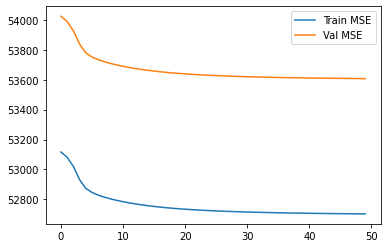

In [44]:
with open(model_training_info_name_path, 'rb') as f:
    train_avg_MSE_vals, val_avg_MSE_vals = pickle.load(f)
plt.figure()
plt.plot(train_avg_MSE_vals, label='Train MSE')
plt.plot(val_avg_MSE_vals, label='Val MSE')
plt.legend()
plt.show()

In [45]:
best_model = PorousMaterialImageAndStrainToStressNet()
best_optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
best_checkpoint = torch.load(model_save_path)
best_epoch = best_checkpoint['epoch']
best_model.load_state_dict(best_checkpoint['model_state_dict'])
best_optimizer.load_state_dict(best_checkpoint['optimizer_state_dict'])
best_train_loss = best_checkpoint['avg_train_loss']
best_val_loss = best_checkpoint['avg_val_loss']

print('Best epoch = {0}, best train avg MSE loss = {1}, best val avg MSE loss = {2}'.format(best_epoch, best_train_loss, best_val_loss))

Best epoch = 49, best train avg MSE loss = 52703.1640625, best val avg MSE loss = 53607.09375


## Test Results

In [61]:
def get_PorousMaterialImageAndStrainToStressNet_test_random_output(model, evaluation_dataloader, criterion):
    model.eval()
    model = model.to(device=device)
    batch_idx = random.randint(0, len(evaluation_dataloader)-1)
    with torch.no_grad():
        for i, eval_batch in enumerate(evaluation_dataloader):
            if i != batch_idx:
                continue
            og_image_batch, strain_batch, SMises_batch = eval_batch
            og_image_batch = og_image_batch.to(dtype=dtype, device=device)
            strain_batch = strain_batch.to(dtype=dtype, device=device)
            SMises_batch = SMises_batch.to(dtype=dtype, device=device)

            pred_SMises_batch = model(og_image_batch, strain_batch)
            og_image_batch = og_image_batch.cpu()
            strain_batch = strain_batch.cpu()
            SMises_batch = SMises_batch.cpu()
            pred_SMises_batch = pred_SMises_batch.cpu()

            for idx in range(len(og_image_batch)):
                fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)

                ax1.imshow(torch.movedim(og_image_batch[idx], 0, 2))
                ax1.set_title('Porous Material Image')

                ax2.plot(strain_batch[idx], pred_SMises_batch[idx], label='Von Mises Stress')
                ax2.set_xlabel('Strain') # mm?
                ax2.set_ylabel('Stress (MPa)')
                ax2.set_title('Predicted Stress Response')

                ax3.plot(strain_batch[idx], SMises_batch[idx], label='Von Mises Stress')
                ax3.set_xlabel('Strain') # mm?
                ax3.set_ylabel('Stress (MPa)')
                ax3.set_title('Ground Truth Stress Response')
                ax3.legend()
                plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


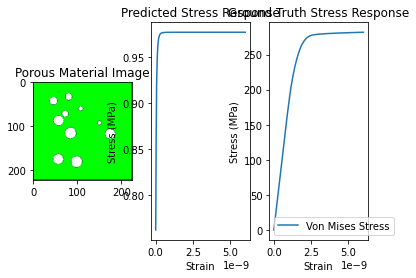

Best val set model: test total MSE = 21332190.0MPa**2, test avg MSE = 53330.4765625MPa**2
Best val set model: test total sqrt(MSE) = 4618.67822265625MPa, test avg sqrt(MSE) = 230.93392944335938MPa


In [65]:
get_PorousMaterialImageAndStrainToStressNet_test_random_output(best_model, test_loader, criterion)
test_total_MSE, test_avg_MSE = get_PorousMaterialImageAndStrainToStressNet_accuracy(best_model, test_loader, criterion)
print('Best val set model: test total MSE = {0}MPa**2, test avg MSE = {1}MPa**2'.format(test_total_MSE, test_avg_MSE))
print('Best val set model: test total sqrt(MSE) = {0}MPa, test avg sqrt(MSE) = {1}MPa'.format(np.sqrt(test_total_MSE), np.sqrt(test_avg_MSE)))